In [260]:
import numpy as np
import matplotlib.pyplot as plt

In [261]:
# Numerical parameters
eps = 1e-12

## Global Parameters

In [262]:
# Non-dimensional parameters
# Damkohler numbers
Dam_tr = 1.0
Dam_ci = 1.4

# Peclet numbers
Pen_tr = 10.0
Pen_ci = 15.0

Pen_tr_s = 10.0
Pen_ci_s = 15.0

# Biot numbers
Bit_tr = 1.0e3
Bit_ci = 3.33

# Marangoni numbers
Man = 1.03

# Switching rate
k_tr = 1.0
k_ci = 30 * k_tr

chi_tr = 30.0
chi_ci = 1.0

print(k_tr * chi_tr, k_ci * chi_ci)

assert k_tr * chi_tr == k_ci * chi_ci

30.0 30.0


In [263]:
# Other parameters
# Length of the cell
L = 1.0

# Light intensity
def f_1(x):
    return np.sin(x) + 2 * np.sin(3 * x)

def f_h(omega):
    return np.array([1.0, 0.0, 2.0, 0.0, 0.0])
    

## Leading Order

### Setting Additional Parameters

In [264]:
# Setup required parameters
alpha = Dam_ci / Dam_tr
eta = Pen_tr / Pen_ci
zeta = Pen_tr * Dam_tr + Pen_ci * Dam_ci
beta = Bit_tr / Bit_ci
xi = Pen_ci * Bit_tr
nu = Dam_tr / Bit_tr

### Apply Boundary Conditions

In [265]:
# Define matrices
U = np.array([
    [alpha, eta],
    [1, -1]
])

In [266]:
# Quadratic coefficients
a = (
    ((eta - 1) / np.sqrt(zeta)) * np.sinh(np.sqrt(zeta)) * np.cosh(np.sqrt(zeta))
    * (eta * (nu * (1 + alpha) * beta + 1) * k_tr - (nu * (1 + alpha) + 1) * k_ci)
)

b = (
    (1 + alpha) * np.cosh(np.sqrt(zeta))
    * (eta * (nu * (1 + alpha) * beta + 1) * k_tr - (nu * (1 + alpha) + 1) * k_ci)
    + ((eta - 1) / np.sqrt(zeta)) * np.sinh(np.sqrt(zeta))
    * (alpha * (nu * (1 + alpha) * beta + 1) * k_tr + (nu * (1 + alpha) + 1) * k_ci)
)

c = (1 + alpha) * (alpha * (nu * (1 + alpha) * beta + 1) * k_tr + (nu * (1 + alpha) + 1) * k_ci)

d = (
    ((eta - 1) / np.sqrt(zeta)) * np.sinh(np.sqrt(zeta))
    + (1 / (chi_tr * k_tr) - 1 / (2 * L)) * np.cosh(np.sqrt(zeta))
    * (eta * (nu * (1 + alpha) * beta + 1) * k_tr - (nu * (1 + alpha) + 1) * k_ci)
)

e = (
    (1 + alpha)
    + (1 / (chi_tr * k_tr) - 1 / (2 * L))
    * (alpha * (nu * (1 + alpha) * beta + 1) * k_tr + (nu * (1 + alpha) + 1) * k_ci)
)

f = -1 / (2 * L)

p = (
    chi_ci * k_ci * np.sqrt(zeta) * np.sinh(np.sqrt(zeta)) * np.cosh(np.sqrt(zeta))
    * (
        ((1 + alpha) / xi) * (k_tr * beta * eta - k_ci)
        + ((alpha + eta) / zeta) * (k_tr * eta - k_ci)
    )
)

q = (
    chi_ci * k_ci * np.sqrt(zeta) * np.sinh(np.sqrt(zeta))
    * (
        alpha * k_tr * (((1 + alpha) * beta) / xi + (alpha + eta) / zeta)
        + k_ci * ((1 + alpha) / xi + (alpha + eta) / zeta)
    )
)

r = (
    chi_ci * k_ci * np.sqrt(zeta) * np.sinh(np.sqrt(zeta))
    * ((1 + alpha * beta) / xi + (alpha + eta) / zeta)
    + np.cosh(np.sqrt(zeta)) * (eta * k_tr + alpha * k_ci)
)

s = alpha * (k_tr - k_ci)

In [267]:
# Solve for B_1
poly = np.poly1d([
    a * q**2 - b * p * q + c * p**2,
    2 * a * q * s - b * p * s - b * q * r + 2 * c * p * r + d * q**2 - e * p * q,
    a * s**2 - b * r * s + c * r**2 + 2 * d * q * s - e * p * s - e * q * r + f * q**2,
    d * s**2 - e * r * s + 2 * f * q * s,
    f * s**2
])
roots = poly.r
print(roots)

[ 6.13668883e+11  2.48794921e-03 -9.26361291e-04  5.82728234e-04]


In [300]:
# Select a root
B_1 = roots[3]

In [301]:
# Solve for B_0
B_0 = -(p * B_1**2 + r * B_1) / (q * B_1 + s)

### Solutions to Leading Order

In [302]:
# Bulk concentrations
def w(y):
    return np.array([B_0, B_1 * np.cosh(y * np.sqrt(zeta))])

def d_w(y):
    return np.array([0, B_1 * np.sqrt(zeta) * np.sinh(y * np.sqrt(zeta))])

def d2_w(y):
    return np.array([0, B_1 * zeta * np.cosh(y * np.sqrt(zeta))])

def c_0(y):
    return U @ w(y)

def c_tr_0(y):
    return alpha * B_0 + eta * B_1 * np.cosh(y * np.sqrt(zeta))

def c_ci_0(y):
    return B_0 - B_1 * np.cosh(y * np.sqrt(zeta))

# Surface concentrations
Delta = nu * (1 + alpha) * (beta * k_tr * c_tr_0(1) + k_ci * c_ci_0(1)) + k_tr * c_tr_0(1) + k_ci * c_ci_0(1) + 1

gamma_0 = (
    (1 / Delta) * (nu * (beta * k_tr * c_tr_0(1) + k_ci * c_ci_0(1)) * np.array([alpha, 1])
    + np.array([k_tr * c_tr_0(1), k_ci * c_ci_0(1)]))
)

gamma_tr_0 = (nu * (beta * k_tr * c_tr_0(1) + k_ci * c_ci_0(1)) * alpha + k_tr * c_tr_0(1)) / Delta

gamma_ci_0 = (nu * (beta * k_tr * c_tr_0(1) + k_ci * c_ci_0(1)) + k_ci * c_ci_0(1)) / Delta

assert abs(gamma_tr_0 - gamma_0[0]) < eps
assert abs(gamma_ci_0 - gamma_0[1]) < eps

assert abs((gamma_tr_0 + gamma_ci_0) - (1 - 1 / Delta)) < eps

### Solution Plots to Leading Order

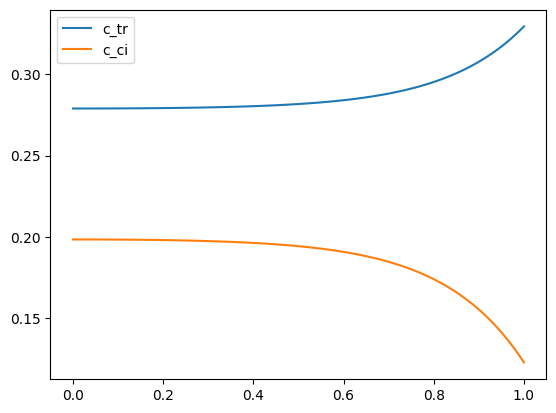

In [303]:
yy = np.linspace(0, 1, 100)

plt.plot(yy, c_tr_0(yy), label="c_tr")
plt.plot(yy, c_ci_0(yy), label="c_ci")
plt.legend()
plt.show()

## First Order

### Setup Constants

In [304]:
# Define matrices
A_s = np.array([
    [Pen_tr_s * Dam_tr, -Pen_tr_s * Dam_ci],
    [-Pen_ci_s * Dam_tr, Pen_ci_s * Dam_ci]
])

P = np.array([
    [Pen_tr, 0],
    [0, Pen_ci]
])

P_s = np.array([
    [Pen_tr_s, 0],
    [0, Pen_ci_s]
])

B = np.array([
    [Bit_tr, 0],
    [0, Bit_ci]
])

K = np.array([
    [k_tr, 0],
    [0, k_ci]
])

M = A_s + P_s @ B @ np.array([
    [k_tr * c_tr_0(1) + 1, k_tr * c_tr_0(1)],
    [k_ci * c_ci_0(1), k_ci * c_ci_0(1) + 1]
])

z = np.ones(2).reshape(1, 2)

I = np.eye(2)

### Expand Solutions in Terms of Unknown Parameters

In [305]:
unknowns = ["A_h", "B_h", "C_h", "D_h", "E_h", "F_h", "G_h", "H_h", "gamma_tr_h", "gamma_ci_h", "S_h", "const"]

def to_arr(vals, omega):
    """Converts a dictionary of values to an array."""
    arr = np.zeros((len(unknowns), len(omega)))
    for i, key in enumerate(unknowns):
        try:
            arr[i, :] = vals[key]
        except KeyError:
            pass
    
    return arr


In [306]:
# Streamfunction
def psi_h(omega, y):
    return to_arr({
        "A_h": y * np.exp(omega * y),
        "B_h": np.exp(omega * y),
        "C_h": y * np.exp(-omega * y),
        "D_h": np.exp(-omega * y),
    }, omega)

def d_psi_h(omega, y):
    return to_arr({
        "A_h": (1 + omega * y) * np.exp(omega * y),
        "B_h": omega * np.exp(omega * y),
        "C_h": (1 - omega * y) * np.exp(-omega * y),
        "D_h": -omega * np.exp(-omega * y),
    }, omega)

def d2_psi_h(omega, y):
    return to_arr({
        "A_h": omega * (2 + omega * y) * np.exp(omega * y),
        "B_h": omega**2 * np.exp(omega * y),
        "C_h": -omega * (2 - omega * y) * np.exp(-omega * y),
        "D_h": omega**2 * np.exp(-omega * y),
    }, omega)

def d3_psi_h(omega, y):
    return to_arr({
        "A_h": omega**2 * (3 + omega * y) * np.exp(omega * y),
        "B_h": omega**3 * np.exp(omega * y),
        "C_h": omega**2 * (3 - omega * y) * np.exp(-omega * y),
        "D_h": -omega**3 * np.exp(-omega * y),
    }, omega)

In [307]:
# Define coefficients for bulk concentration
def a_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) + zeta)) * to_arr({
        "A_h": 1,
    }, omega)

def b_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) + zeta)**2) * to_arr({
        "A_h": -2 * (omega + np.sqrt(zeta)),
        "B_h": 2 * omega * np.sqrt(zeta) + zeta,
    }, omega)

def c_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) - zeta)) * to_arr({
        "A_h": 1,
    }, omega)

def d_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) - zeta)**2) * to_arr({
        "A_h": 2 * (omega - np.sqrt(zeta)),
        "B_h": 2 * omega * np.sqrt(zeta) - zeta,
    }, omega)

def e_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) - zeta)) * to_arr({
        "A_h": 1,
        "B_h": 2 * omega,
    }, omega)

def f_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) - zeta)**2) * to_arr({
        "A_h": -2 * (omega - np.sqrt(zeta)),
        "B_h": (
            2 * omega * np.sqrt(zeta) - zeta
            - 4 * omega * (omega - np.sqrt(zeta))
        ),
    }, omega)

def g_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) + zeta)) * to_arr({
        "A_h": 1,
        "B_h": 2 * omega,
    }, omega)

def h_p(omega):
    return (1 / (2 * omega * np.sqrt(zeta) + zeta)**2) * to_arr({
        "A_h": 2 * (omega + np.sqrt(zeta)),
        "B_h": (
            2 * omega * np.sqrt(zeta) + zeta
            + 4 * omega * (omega + np.sqrt(zeta))
        ),
    }, omega)

In [308]:
# Bulk concentration
def p_h_0(omega, y):
    eq_1 = to_arr({
        "E_h": np.sinh(omega * y),
        "F_h": np.cosh(omega * y),
    }, omega)
    eq_2 = to_arr({
        "G_h": np.sinh(np.sqrt(zeta + omega**2) * y),
        "H_h": np.cosh(np.sqrt(zeta + omega**2) * y),
    }, omega)

    return np.array([eq_1, eq_2])

def p_h_1(omega, y):
    eq_1 = to_arr({
        "const": -B_0,
    }, omega)
    eq_2 = -B_1 * (1 + zeta / omega**2) * to_arr({
        "const": np.cosh(np.sqrt(zeta) * y),
    }, omega)

    return f_h(omega) * np.array([eq_1, eq_2])

def p_h_2_s(omega, y):
    return (
        (a_p(omega) * y + b_p(omega)) * np.exp((omega + np.sqrt(zeta)) * y)
        + (c_p(omega) * y + d_p(omega)) * np.exp((omega - np.sqrt(zeta)) * y)
        + (e_p(omega) * y + f_p(omega)) * np.exp((-omega + np.sqrt(zeta)) * y)
        + (g_p(omega) * y + h_p(omega)) * np.exp((-omega - np.sqrt(zeta)) * y)
    )

def p_h_2(omega, y):
    return (
        -((1.j * omega * np.sqrt(zeta) * B_1 * Pen_ci) / (2 * (alpha + eta)))
        * p_h_2_s(omega, y)
        * np.array([eta * (eta - 1), alpha + eta**2])[:, np.newaxis, np.newaxis]
    )

def p_h(omega, y):
    return p_h_0(omega, y) + p_h_1(omega, y) + p_h_2(omega, y)

In [309]:
# Bulk concentration derivative
def d_p_h_0(omega, y):
    eq_1 = omega *to_arr({
        "E_h": np.cosh(omega * y),
        "F_h": np.sinh(omega * y),
    }, omega)
    eq_2 = np.sqrt(zeta + omega**2) * to_arr({
        "G_h": np.cosh(np.sqrt(zeta + omega**2) * y),
        "H_h": np.sinh(np.sqrt(zeta + omega**2) * y),
    }, omega)

    return np.array([eq_1, eq_2])

def d_p_h_1(omega, y):
    eq_1 = to_arr({}, omega)
    eq_2 = -B_1 * (1 + zeta / omega**2) * to_arr({
        "const": np.sqrt(zeta) * np.sinh(np.sqrt(zeta) * y),
    }, omega)

    return f_h(omega) * np.array([eq_1, eq_2])

def d_p_h_2_s(omega, y):
    return (
        b_p(omega) * np.exp((omega + np.sqrt(zeta)) * y)
        + d_p(omega) * np.exp((omega - np.sqrt(zeta)) * y)
        + f_p(omega) * np.exp((-omega + np.sqrt(zeta)) * y)
        + h_p(omega) * np.exp((-omega - np.sqrt(zeta)) * y)
        + (omega + np.sqrt(zeta)) * (a_p(omega) * y + b_p(omega)) * np.exp((omega + np.sqrt(zeta)) * y)
        + (omega - np.sqrt(zeta)) * (c_p(omega) * y + d_p(omega)) * np.exp((omega - np.sqrt(zeta)) * y)
        + (-omega + np.sqrt(zeta)) * (e_p(omega) * y + f_p(omega)) * np.exp((-omega + np.sqrt(zeta)) * y)
        + (-omega - np.sqrt(zeta)) * (g_p(omega) * y + h_p(omega)) * np.exp((-omega - np.sqrt(zeta)) * y)
    )

def d_p_h_2(omega, y):
    return (
        -((1.j * omega * np.sqrt(zeta) * B_1 * Pen_ci) / (2 * (alpha + eta)))
        * d_p_h_2_s(omega, y)
        * np.array([eta * (eta - 1), alpha + eta**2])[:, np.newaxis, np.newaxis]
    )

def d_p_h(omega, y):
    return d_p_h_0(omega, y) + d_p_h_1(omega, y) + d_p_h_2(omega, y)

### Apply Boundary Conditions

In [310]:
# No-slip, no-penetration conditions
def no_slip(omega):
    return np.array([d_psi_h(omega, 0), psi_h(omega, 0)])

In [311]:
# Kinematic condition
def kinematic(omega):
    return np.array([psi_h(omega, 1)])

In [312]:
# Normal stress balance
def normal_stress(omega):
    lhs = d3_psi_h(omega, 1) - 3 * omega**2 * d_psi_h(omega, 1)
    rhs = 1.j * omega**3 * (1 - Man * np.log(Delta)) * to_arr({
        "S_h": 1,
    }, omega)

    return np.array([lhs - rhs])

In [313]:
# No-flux condition
def no_flux(omega):
    return d_p_h(omega, 0)

In [314]:
# Surface excess concentration equations
def J_h(omega):
    S_vec = np.tile(to_arr({"S_h": 1}, omega), (2, 1, 1))
    eq_2 = p_h(omega, 1) + S_vec * d_w(1)[:, np.newaxis, np.newaxis]
    eq_3 = (1 / Delta) * np.tensordot(K @ U, eq_2, axes=1)

    gamma_tr_vec = to_arr({
        "gamma_tr_h": 1,
    }, omega)
    gamma_ci_vec = to_arr({
        "gamma_ci_h": 1,
    }, omega)
    eq_5 = -(K @ U @ w(1))[:, np.newaxis, np.newaxis] * np.tile((gamma_tr_vec + gamma_ci_vec), (2, 1, 1))

    eq_6 = -np.array([gamma_tr_vec, gamma_ci_vec])

    return np.tensordot(B, eq_3 + eq_5 + eq_6, axes=1)

def surf_excess(omega):
    eq_1 = 1.j * omega * (np.tile(d_psi_h(omega, 1), (2, 1, 1)) * (P_s @ gamma_0)[:, np.newaxis, np.newaxis])

    gamma_tr_vec = to_arr({"gamma_tr_h": 1}, omega)
    gamma_ci_vec = to_arr({"gamma_ci_h": 1}, omega)
    gamma_vec = np.array([gamma_tr_vec, gamma_ci_vec])
    eq_2 = omega**2 * gamma_vec

    eq_3 = -np.tensordot(P_s, J_h(omega), axes=1)

    eq_4 = f_h(omega) * to_arr({"const": 1}, omega)
    eq_5 = gamma_vec + np.tile(eq_4, (2, 1, 1)) * gamma_0[:, np.newaxis, np.newaxis]
    eq_6 = np.tensordot(A_s, eq_5, axes=1)

    return eq_1 + eq_2 + eq_3 + eq_6

In [315]:
# Tangential stress balance
def tangential_stress(omega):
    lhs = d2_psi_h(omega, 1) + omega**2 * psi_h(omega, 1)
    rhs = -1.j * omega * Man * Delta * to_arr({
        "gamma_tr_1": 1,
        "gamma_ci_1": 1,
    }, omega)

    return np.array([lhs - rhs])

In [316]:
# Mass balance
def mass_balance(omega):
    S_vec = np.tile(to_arr({"S_h": 1}, omega), (2, 1, 1))
    eq_1 = d_p_h(omega, 1) + S_vec * d2_w(1)[:, np.newaxis, np.newaxis]
    lhs = k_tr * chi_tr * np.tensordot(U, eq_1, axes=1)

    rhs = -np.tensordot(P, J_h(omega), axes=1)

    return lhs - rhs

In [317]:
# Collate equations
def form_equations(omega):
    return np.concatenate([
        no_slip(omega),
        kinematic(omega),
        normal_stress(omega),
        no_flux(omega),
        surf_excess(omega),
        tangential_stress(omega),
        mass_balance(omega),
    ], axis=0)

### Solutions for Constants of Integration

In [318]:
omega = (np.arange(5) + 1) * (np.pi / L)

In [319]:
sys = form_equations(omega)
f = sys[:, -1, :]

In [330]:
# Compute unknowns
sols = np.array([np.linalg.solve(sys[:, :-1, i], f[:, i]) for i in range(len(omega))])

### Test Against Analytical Solutions

### Solutions to First Order